In [2]:
import scipy.io
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)

from lab8_common import *

sensor_mat = scipy.io.loadmat('data/sensors.mat')

sensor_data = sensor_mat['sonars']
true_states = sensor_mat['true_states']

room_map = create_map()

In [3]:
def get_single_likelihood(sensor_vector, scatter_vector):
    diff = np.array(sensor_vector) - np.array(scatter_vector)
    return np.exp( -15 * np.sum( np.abs(  diff )))

def get_normalized_likelihoods(timestep_sensor, scatter_points, room_map):
    vectorized_scatter = cast_rays( scatter_points, room_map )
    likelihoods = np.zeros(len(scatter_points[0]))
    for x in xrange(len(vectorized_scatter)):
        likelihoods[x] = get_single_likelihood(timestep_sensor, vectorized_scatter[x])
    return likelihoods / np.sum(likelihoods)

def resample(scatter_points,  likelihoods):
    scatter_len = len(scatter_points[0])
    resample_indeces = np.random.choice(xrange(scatter_len), scatter_len, p=likelihoods)
    sampled_index = 0
    new_scatter = copy.deepcopy(scatter_points)
    for sampled_value in resample_indeces:
        new_scatter[:,sampled_index] = add_noise(sampled_value, scatter_points)
        sampled_index += 1
    return new_scatter
    
def add_noise(sampled_value, scatter_points, noise=1 ):
    s =  scatter_points[:,sampled_value]# 
    s[0] += np.random.uniform(-0.002, 0.002)
    s[1] += np.random.uniform(-0.002, 0.002)
    s[2] += np.random.uniform(0, 2 * np.pi)
    return s

def visualize( true_states, room_map, all_scatter_points, movie=True, frame=0, expected=None ):
    if movie:
        for t in xrange(len(true_states[0])):
            plt.figure( 1 )
            plt.clf()
            show_map( room_map )
            plt.scatter(true_states[0,:t], true_states[1,:t])
            plt.scatter(all_scatter_points[t][0], all_scatter_points[t][1], c="red")
            #plt.scatter(expected_points[0,:t], expected_points[1,:t], c="green")
            plt.pause(0.001)
        plt.close()
    else:
        fig = plt.figure(0)
        ax = fig.add_subplot(111, aspect='equal')
        show_map( room_map )
        c1, = ax.plot(true_states[0,:frame], true_states[1,:frame], label="Sonar State")
        ax.scatter(all_scatter_points[frame-1][0], all_scatter_points[frame-1][1], c="red")
        c2, = ax.plot(expected_points[:,0], expected_points[:,1], c="green", label="Expected State")
        plt.title("Particle Filter")
        ax.legend(handles=[c1, c2], loc=0)
        plt.show()

In [12]:
num_scatter_points = 10000
scatter_points = np.random.rand(3, num_scatter_points)
scatter_points[2] = np.random.uniform(0, 2*np.pi, num_scatter_points)

all_scatter_points = []
expected_points = []

for t in xrange(len(true_states[0])):
    likelihoods =  get_normalized_likelihoods(sensor_data[:,t] , scatter_points , room_map )
    scatter_points = resample( scatter_points, likelihoods )
    all_scatter_points.append( scatter_points )
    expected_points.append(np.mean(scatter_points, axis=1))

expected_points =  np.array(expected_points)
    


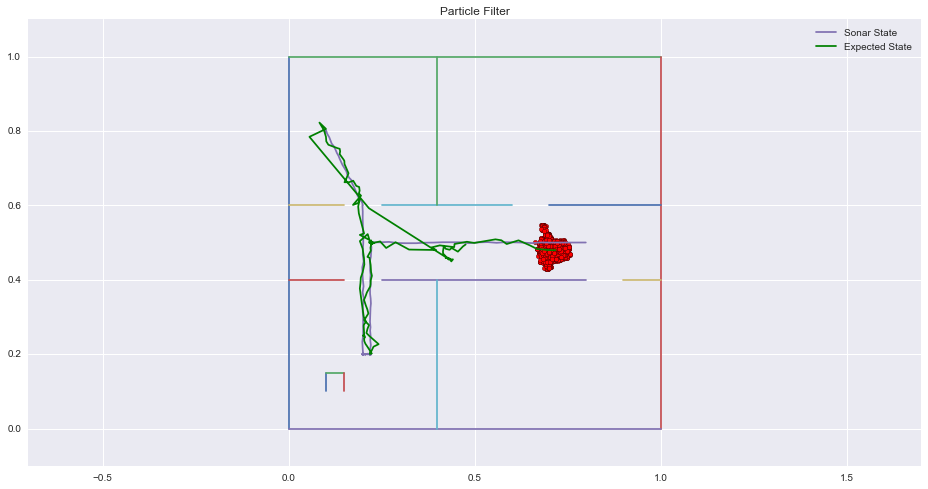

In [13]:
visualize( true_states, room_map, all_scatter_points, False, len(true_states[0]), expected_points)
